# Ejercicio 2
Modificando los archivos demo-art.py y ART.py (que se encuentran en
el directorio python-ART) o usando Octave con los archivos de AIR-
Tools

* Implementar el cálculo del error de reconstruccion

Los errores son implementados facilemente mediante el paquete metrics de skimage, que contiene varias métricas de error. En este caso se usan
* Mean Squared Error (MSE): $$MSE = \frac{1}{n} \sum_{i=1}^{n} (x_i - y_i)^2$$
* Peak Signal to Noise Ratio (PSNR): $$PSNR = 10 \cdot \log_{10} \left( \frac{MAX^2}{MSE} \right)$$,
donde MAX es el máximo valor posible de la imágen. En este caso 255.
* Structural Similarity Index (SSIM): $$SSIM = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$,
donde
$\mu_x$ es la media muestral de píxeles de $x$;
$\mu_y$ es la media muestral de píxeles de $y$;
$\sigma_x^2$ es la varianza de $x$;
$\sigma_y^2$ es la varianza de $y$;
$\sigma_{xy}$ es la covarianza de $x$ e $y$;
$c_1=(k_1L)^2$, $c_2=(k_2L)^2$ son dos variables para estabilizar la división con denominador débil;
$L$ es el rango dinámico de los valores de píxeles (típicamente esto es $2^{\#bits\ per\ pixel}-1$);
$k_1=0.01$ y $k_2=0.03$ por defecto.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.io import loadmat
from scipy.stats import poisson
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2

* Analizar la influencia del número de ángulos, de detectores y del nivel de ruido sobre el error de reconstrucción utilizando el método de ART (o Kaczmarz)

## Método de ART

### Error de reconstrucción con respecto al número de ángulos
Para esto primero utilizamos el AIRtools con MATLAB para generar las proyecciones y reconstrucciones. Luego, con el código de Python, calculamos los errores de reconstrucción.
Primero realizamos seteamos los parámetros que dejamos fijos. La imágen utilizada es el fantoma shepp-logan generado con una resolución de NxN píxles con $N=256$. Se utilizan un número de discretización $p = 360$, un error relativo de $\eta = 1e-4$ y un número de iteraciones $k = 100$. Con estos parámetros fijos se varía la cantidad de ángulos $\theta$ utilizados, se toman valores de $\theta \in [0,\:180]$ variando el número de ángulos en 36, 60, 180 y 360.

In [2]:
path = r"C:/Users/Propietario/Desktop/ib/5-Maestría/Imágenes Médicas/Practicas/Practica4/AIRtools/"

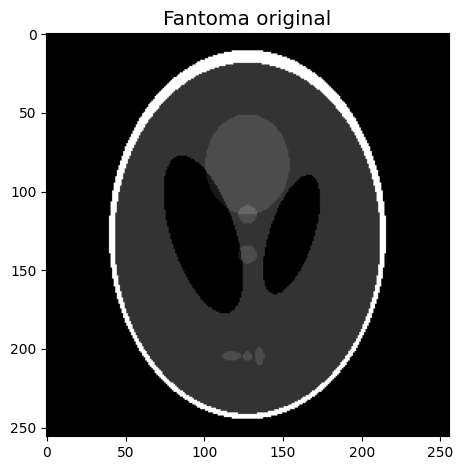

In [3]:
files_angulos = ["ART_angles0.5.mat", "ART_angles1.mat", "ART_angles3.mat", "ART_angles5.mat"]
num_angulos = [360, 180, 60, 36]
fantoma_path = os.path.join(path, "fantoma256.mat")
fantoma_original = loadmat(fantoma_path)['fantoma']
plt.imshow(fantoma_original, cmap='gray')
plt.title('Fantoma original', fontsize='x-large')
plt.tight_layout()
plt.savefig('fantoma_original.pdf')
plt.show()

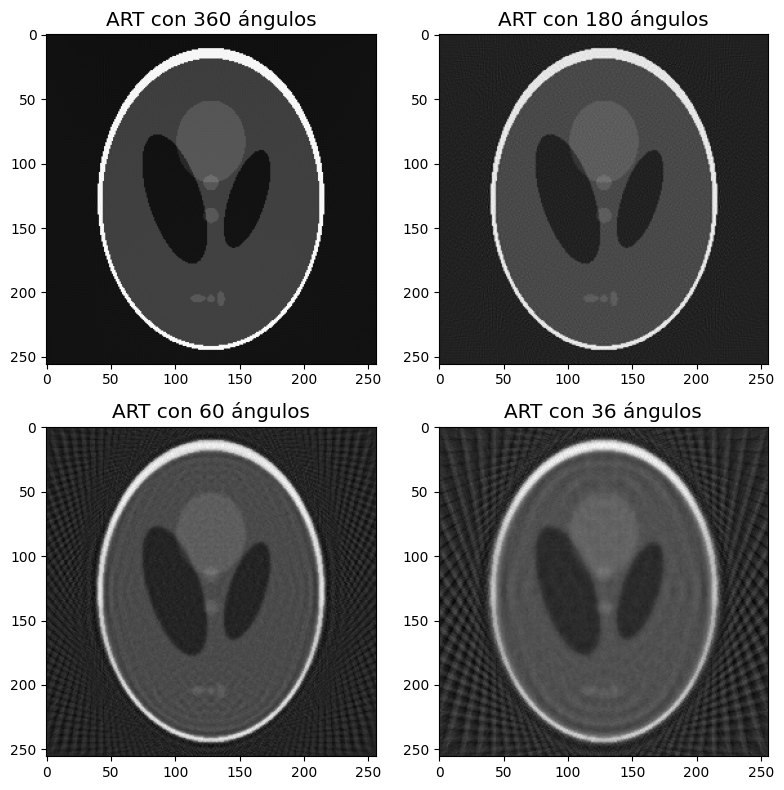

In [4]:
fig, ax = plt.subplots(2,2,figsize=(8, 8))
for i, (n, file) in enumerate(zip(num_angulos, files_angulos)):
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['ART']
    if i == 0 or i == 1:
        ax[0,i].imshow(reconstruccion_fantoma, cmap='gray')
        ax[0,i].set_title('ART con {} ángulos'.format(n), fontsize='x-large')
    else:
        ax[1,i%2].imshow(reconstruccion_fantoma, cmap='gray')
        ax[1,i%2].set_title('ART con {} ángulos'.format(n), fontsize='x-large')
plt.tight_layout()
plt.savefig('ART_angulos.pdf')
plt.show()

Calculemos el error de reconstrucción para cada caso.

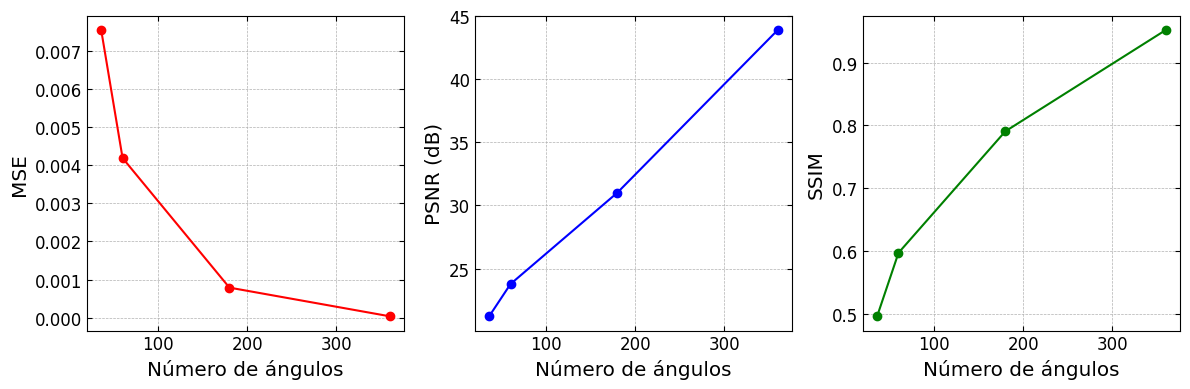

In [73]:
mse_a = []
psnr_a = []
ssim_a = []
for n, file in zip(num_angulos, files_angulos): 
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['ART']
    mse_a.append(mse(fantoma_original, reconstruccion_fantoma))
    psnr_a.append(psnr(fantoma_original, reconstruccion_fantoma))
    ssim_a.append(ssim(fantoma_original, reconstruccion_fantoma, data_range=reconstruccion_fantoma.max()-reconstruccion_fantoma.min()))

fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot(num_angulos, mse_a, '-o', color='red')
ax[0].set_xlabel('Número de ángulos', fontsize='x-large')
ax[0].set_ylabel('MSE', fontsize='x-large')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].grid(linestyle = '--', lw = 0.5)
ax[1].plot(num_angulos, psnr_a, '-o', color = 'blue')
ax[1].set_xlabel('Número de ángulos', fontsize='x-large')
ax[1].set_ylabel('PSNR (dB)', fontsize='x-large')
ax[1].grid(linestyle = '--', lw = 0.5)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].plot(num_angulos, ssim_a, '-o', color = 'green')
ax[2].set_xlabel('Número de ángulos', fontsize='x-large')
ax[2].set_ylabel('SSIM', fontsize='x-large')
ax[2].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].grid(linestyle = '--', lw = 0.5)
plt.tight_layout()
plt.savefig('ART_metricas_angulos.pdf')
plt.show()

### Error de reconstrucción como función del número de detectores

Se realizaron las mismas simulaciones que en el caso anterior, cambiamos el número de detectores de la imágen de 256x256, variando el número de detectores p en 30, 60, 90, 180 y 360, se manutvo el ruido relativo en 1e-4, el número de iteraciones en 100 y el número de ángulos en 360 entre 0 y 180 grados.

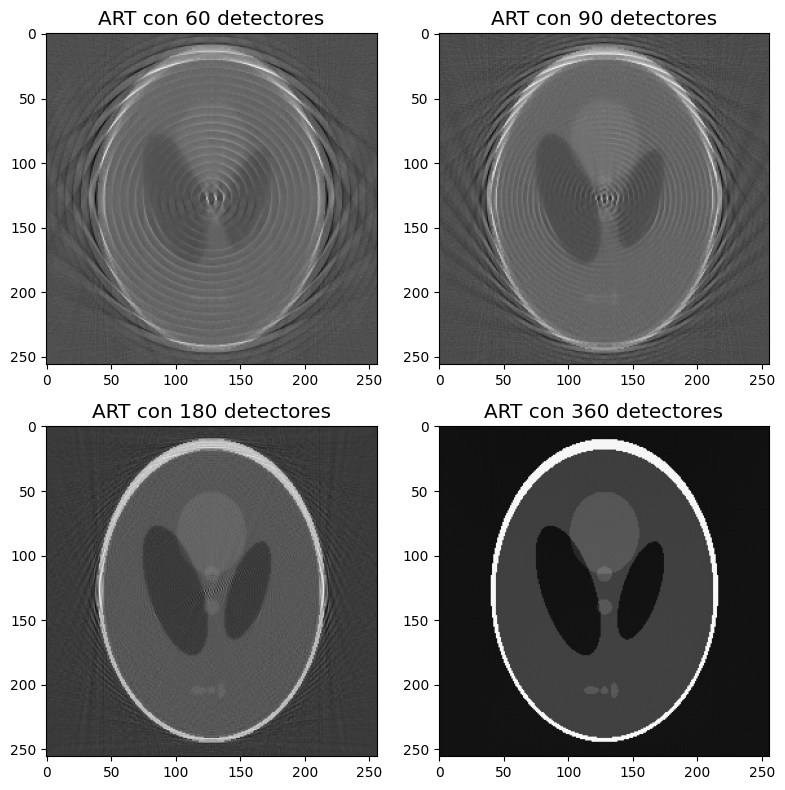

In [32]:
files_detectores = ["ART_detectorsv260.mat", "ART_detectorsv290.mat", "ART_detectorsv2180.mat", "ART_detectorsv2360.mat"]
num_detectores = [60, 90, 180, 360]
fig, ax = plt.subplots(2,2,figsize=(8, 8))
for i, (n, file) in enumerate(zip(num_detectores, files_detectores)):
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['ART']
    if i == 0 or i == 1:
        ax[0,i].imshow(reconstruccion_fantoma, cmap='gray')
        ax[0,i].set_title('ART con {} detectores'.format(n), fontsize='x-large')
    else:
        ax[1,i%2].imshow(reconstruccion_fantoma, cmap='gray')
        ax[1,i%2].set_title('ART con {} detectores'.format(n), fontsize='x-large')
plt.tight_layout()
plt.savefig('ART_detectores.pdf')
plt.show()

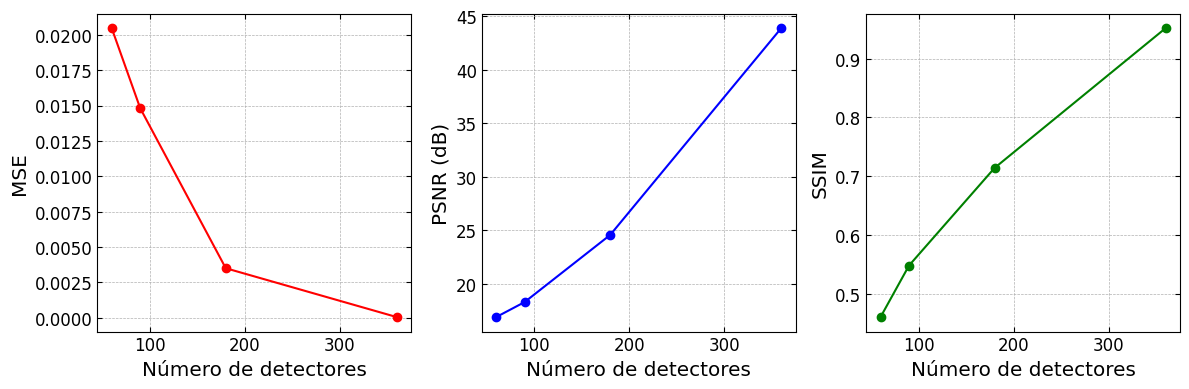

In [26]:
mse_detectors = []
psnr_detectors = []
ssim_detectors = []
for n, file in zip(num_detectores, files_detectores): 
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['ART']
    mse_detectors.append(mse(fantoma_original, reconstruccion_fantoma))
    psnr_detectors.append(psnr(fantoma_original, reconstruccion_fantoma))
    ssim_detectors.append(ssim(fantoma_original, reconstruccion_fantoma, data_range=reconstruccion_fantoma.max()-reconstruccion_fantoma.min()))

fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot(num_detectores, mse_detectors, '-o', color='red')
ax[0].set_xlabel('Número de detectores', fontsize='x-large')
ax[0].set_ylabel('MSE', fontsize='x-large')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].grid(linestyle = '--', lw = 0.5)
ax[1].plot(num_detectores, psnr_detectors, '-o', color = 'blue')
ax[1].set_xlabel('Número de detectores', fontsize='x-large')
ax[1].set_ylabel('PSNR (dB)', fontsize='x-large')
ax[1].grid(linestyle = '--', lw = 0.5)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].plot(num_detectores, ssim_detectors, '-o', color = 'green')
ax[2].set_xlabel('Número de detectores', fontsize='x-large')
ax[2].set_ylabel('SSIM', fontsize='x-large')
ax[2].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].grid(linestyle = '--', lw = 0.5)
plt.tight_layout()
plt.savefig('ART_metricas_detectores.pdf')
plt.show()

### Error de reconstrucción en función del ruido

Para analizar el efecto del ruido en la reconstrucción, se realiza la imágen de NxN con $N = 256$, 360 angulos para $\theta \in [0,\: 180]$, detectores $p = 360$ y $k = 100$ iteraciones. Se varió el ruido relativo en $\eta = 0.1, ~ 0.01, ~ 0.001, ~ 0.0001, ~ 0.00001$.

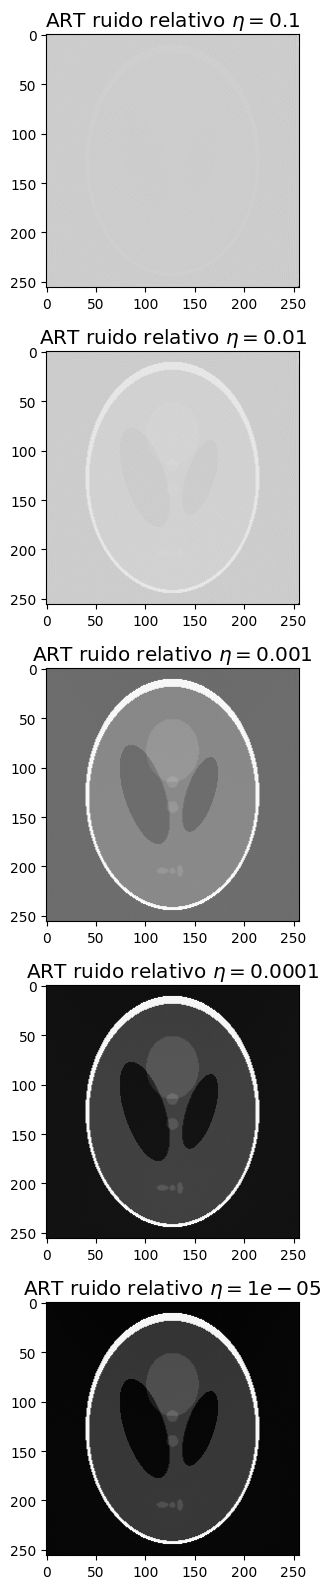

In [26]:
files_ruido = ["ART_rnoise0.1.mat", "ART_rnoise0.01.mat", "ART_rnoise0.001.mat", "ART_rnoise0.0001.mat", "ART_rnoise1e-05.mat"]
eta_list = [0.1, 0.01, 0.001, 1e-4, 1e-5]
fig, ax = plt.subplots(5,1,figsize=(10, 16))
for i, (eta, file) in enumerate(zip(eta_list, files_ruido)):
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['ART']
    ax[i].imshow(reconstruccion_fantoma, cmap='gray')
    ax[i].set_title('ART ruido relativo $\eta = {}$'.format(eta), fontsize='x-large')
plt.tight_layout()
plt.savefig('ART_rnoise.pdf')
plt.show()

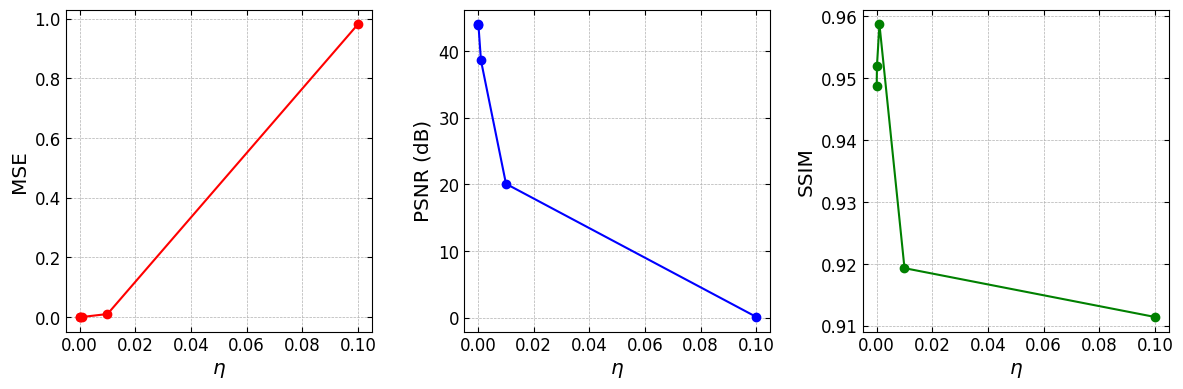

In [6]:
mse_noise = []
psnr_noise = []
ssim_noise = []
for n, file in zip(eta_list, files_ruido): 
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['ART']
    mse_noise.append(mse(fantoma_original, reconstruccion_fantoma))
    psnr_noise.append(psnr(fantoma_original, reconstruccion_fantoma))
    ssim_noise.append(ssim(fantoma_original, reconstruccion_fantoma, data_range=reconstruccion_fantoma.max()-reconstruccion_fantoma.min()))

fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot(eta_list, mse_noise, '-o', color='red')
ax[0].set_xlabel('$\eta$', fontsize='x-large')
ax[0].set_ylabel('MSE', fontsize='x-large')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].grid(linestyle = '--', lw = 0.5)
ax[1].plot(eta_list, psnr_noise, '-o', color = 'blue')
ax[1].set_xlabel('$\eta$', fontsize='x-large')
ax[1].set_ylabel('PSNR (dB)', fontsize='x-large')
ax[1].grid(linestyle = '--', lw = 0.5)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].plot(eta_list, ssim_noise, '-o', color = 'green')
ax[2].set_xlabel('$\eta$', fontsize='x-large')
ax[2].set_ylabel('SSIM', fontsize='x-large')
ax[2].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].grid(linestyle = '--', lw = 0.5)
plt.tight_layout()
plt.savefig('ART_metricas_ruido.pdf')
plt.show()

## Análisis para ART simétrico, aleatorio y simultaneo

Se realizó el mismo análisis que el caso anterior pero esta vez para tres métodos alternativos de ART (simétrico, aleatorio y simultaneo). La misma imagen de 256x256 fue utilizada para realizar las variaciones exactamente como se realizó anteriromente

### Variando los ángulos

In [107]:
files_angulos_sym = ["symART_angles0.5.mat", "symART_angles1.mat", "symART_angles3.mat", "symART_angles5.mat"]
files_angulos_rand = ["randART_angles0.5.mat", "randART_angles1.mat", "randART_angles3.mat", "randART_angles5.mat"]
files_angulos_sart = ["SART_angles0.5.mat", "SART_angles1.mat", "SART_angles3.mat", "SART_angles5.mat"]
# path_test = os.path.join(path, "symART_angles0.5.mat")
# print(loadmat(path_test).keys())

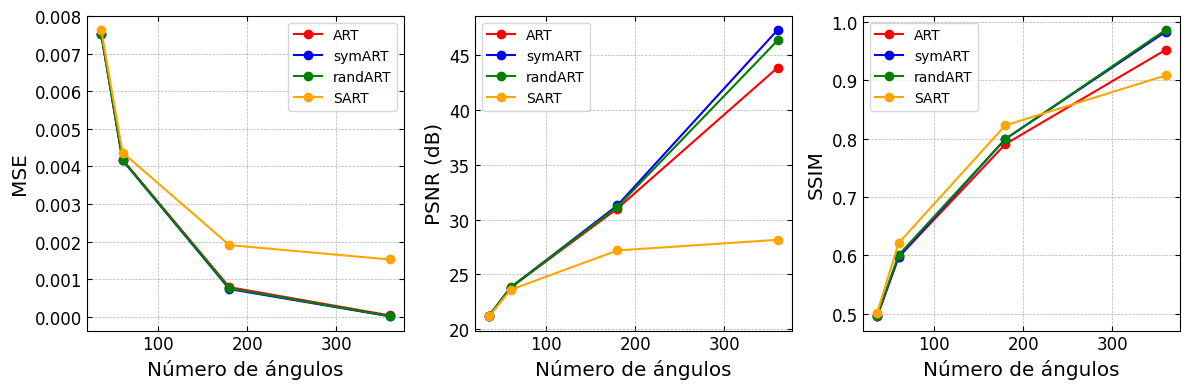

In [118]:
mse_a = []
mse_sym = []
mse_rand = []
mse_sart = []
psnr_a = []
psnr_sym = []
psnr_rand = []
psnr_sart = []
ssim_a = []
ssim_sym = []
ssim_rand = []
ssim_sart = []

for file_art, file_sym, file_rand, file_sart in zip( files_angulos, files_angulos_sym, files_angulos_rand, files_angulos_sart): 
    path_actual = os.path.join(path, file_art)
    path_sym = os.path.join(path, file_sym)
    path_rand = os.path.join(path, file_rand)
    path_sart = os.path.join(path, file_sart)
    
    reconstruccion_art = loadmat(path_actual)['ART']
    reconstruccion_sym = loadmat(path_sym)['symART']
    reconstruccion_rand = loadmat(path_rand)['randART']
    reconstruccion_sart = loadmat(path_sart)['SART']

    mse_a.append(mse(fantoma_original, reconstruccion_art))
    psnr_a.append(psnr(fantoma_original, reconstruccion_art))
    ssim_a.append(ssim(fantoma_original, reconstruccion_art, data_range=reconstruccion_art.max()-reconstruccion_art.min()))

    mse_sym.append(mse(fantoma_original, reconstruccion_sym))
    psnr_sym.append(psnr(fantoma_original, reconstruccion_sym))
    ssim_sym.append(ssim(fantoma_original, reconstruccion_sym, data_range=reconstruccion_sym.max()-reconstruccion_sym.min()))

    mse_rand.append(mse(fantoma_original, reconstruccion_rand))
    psnr_rand.append(psnr(fantoma_original, reconstruccion_rand))
    ssim_rand.append(ssim(fantoma_original, reconstruccion_rand, data_range=reconstruccion_rand.max()-reconstruccion_rand.min()))

    mse_sart.append(mse(fantoma_original, reconstruccion_sart))
    psnr_sart.append(psnr(fantoma_original, reconstruccion_sart))
    ssim_sart.append(ssim(fantoma_original, reconstruccion_sart, data_range=reconstruccion_sart.max()-reconstruccion_sart.min()))


fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot(num_angulos, mse_a, '-o', color='red')
ax[0].plot(num_angulos, mse_sym, '-o', color='blue')
ax[0].plot(num_angulos, mse_rand, '-o', color='green')
ax[0].plot(num_angulos, mse_sart, '-o', color='orange')
ax[0].legend(['ART', 'symART', 'randART', 'SART'])
ax[0].set_xlabel('Número de ángulos', fontsize='x-large')
ax[0].set_ylabel('MSE', fontsize='x-large')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].grid(linestyle = '--', lw = 0.5)
ax[1].plot(num_angulos, psnr_a, '-o', color = 'red')
ax[1].plot(num_angulos, psnr_sym, '-o', color = 'blue')
ax[1].plot(num_angulos, psnr_rand, '-o', color = 'green')
ax[1].plot(num_angulos, psnr_sart, '-o', color = 'orange')
ax[1].legend(['ART', 'symART', 'randART', 'SART'])
ax[1].set_xlabel('Número de ángulos', fontsize='x-large')
ax[1].set_ylabel('PSNR (dB)', fontsize='x-large')
ax[1].grid(linestyle = '--', lw = 0.5)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].plot(num_angulos, ssim_a, '-o', color = 'red')
ax[2].plot(num_angulos, ssim_sym, '-o', color = 'blue')
ax[2].plot(num_angulos, ssim_rand, '-o', color = 'green')
ax[2].plot(num_angulos, ssim_sart, '-o', color = 'orange')
ax[2].legend(['ART', 'symART', 'randART', 'SART'])
ax[2].set_xlabel('Número de ángulos', fontsize='x-large')
ax[2].set_ylabel('SSIM', fontsize='x-large')
ax[2].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].grid(linestyle = '--', lw = 0.5)
plt.tight_layout()
plt.savefig('metricas_angulos.pdf')
plt.show()

### Variando los detectores

In [111]:
files_detectores = ["ART_detectorsv260.mat", "ART_detectorsv290.mat", "ART_detectorsv2180.mat", "ART_detectorsv2360.mat"]
files_detectores_sym = ["symART_detectorsv260.mat", "symART_detectorsv290.mat", "symART_detectorsv2180.mat", "symART_detectorsv2360.mat"]
files_detectores_rand = ["randART_detectorsv260.mat", "randART_detectorsv290.mat", "randART_detectorsv2180.mat", "randART_detectorsv2360.mat"]
files_detectores_sart = ["SART_detectorsv260.mat", "SART_detectorsv290.mat", "SART_detectorsv2180.mat", "SART_detectorsv2360.mat"]
num_detectores = [60, 90, 180, 360]

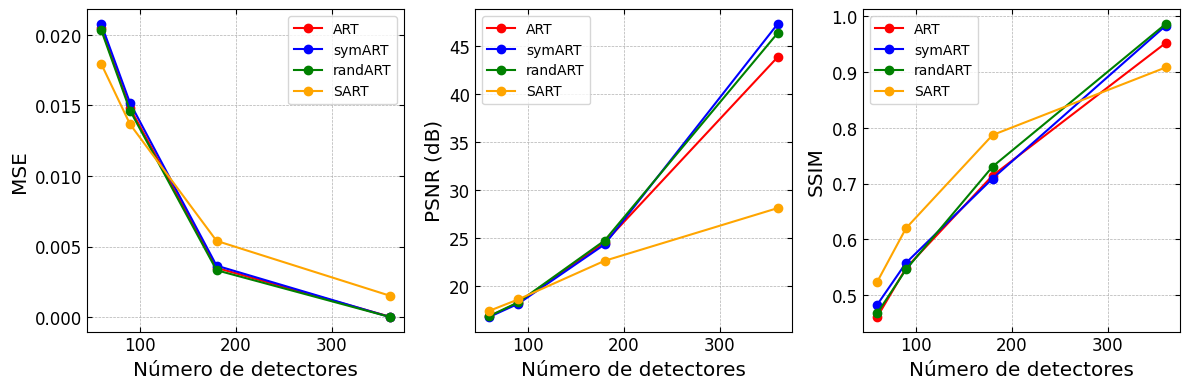

In [119]:
mse_a = []
mse_sym = []
mse_rand = []
mse_sart = []
psnr_a = []
psnr_sym = []
psnr_rand = []
psnr_sart = []
ssim_a = []
ssim_sym = []
ssim_rand = []
ssim_sart = []

for file_art, file_sym, file_rand, file_sart in zip( files_detectores, files_detectores_sym, files_detectores_rand, files_detectores_sart): 
    path_actual = os.path.join(path, file_art)
    path_sym = os.path.join(path, file_sym)
    path_rand = os.path.join(path, file_rand)
    path_sart = os.path.join(path, file_sart)
    
    reconstruccion_art = loadmat(path_actual)['ART']
    reconstruccion_sym = loadmat(path_sym)['symART']
    reconstruccion_rand = loadmat(path_rand)['randART']
    reconstruccion_sart = loadmat(path_sart)['SART']

    mse_a.append(mse(fantoma_original, reconstruccion_art))
    psnr_a.append(psnr(fantoma_original, reconstruccion_art))
    ssim_a.append(ssim(fantoma_original, reconstruccion_art, data_range=reconstruccion_art.max()-reconstruccion_art.min()))

    mse_sym.append(mse(fantoma_original, reconstruccion_sym))
    psnr_sym.append(psnr(fantoma_original, reconstruccion_sym))
    ssim_sym.append(ssim(fantoma_original, reconstruccion_sym, data_range=reconstruccion_sym.max()-reconstruccion_sym.min()))

    mse_rand.append(mse(fantoma_original, reconstruccion_rand))
    psnr_rand.append(psnr(fantoma_original, reconstruccion_rand))
    ssim_rand.append(ssim(fantoma_original, reconstruccion_rand, data_range=reconstruccion_rand.max()-reconstruccion_rand.min()))

    mse_sart.append(mse(fantoma_original, reconstruccion_sart))
    psnr_sart.append(psnr(fantoma_original, reconstruccion_sart))
    ssim_sart.append(ssim(fantoma_original, reconstruccion_sart, data_range=reconstruccion_sart.max()-reconstruccion_sart.min()))


fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot(num_detectores, mse_a, '-o', color='red')
ax[0].plot(num_detectores, mse_sym, '-o', color='blue')
ax[0].plot(num_detectores, mse_rand, '-o', color='green')
ax[0].plot(num_detectores, mse_sart, '-o', color='orange')
ax[0].legend(['ART', 'symART', 'randART', 'SART'])
ax[0].set_xlabel('Número de detectores', fontsize='x-large')
ax[0].set_ylabel('MSE', fontsize='x-large')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].grid(linestyle = '--', lw = 0.5)
ax[1].plot(num_detectores, psnr_a, '-o', color = 'red')
ax[1].plot(num_detectores, psnr_sym, '-o', color = 'blue')
ax[1].plot(num_detectores, psnr_rand, '-o', color = 'green')
ax[1].plot(num_detectores, psnr_sart, '-o', color = 'orange')
ax[1].legend(['ART', 'symART', 'randART', 'SART'])
ax[1].set_xlabel('Número de detectores', fontsize='x-large')
ax[1].set_ylabel('PSNR (dB)', fontsize='x-large')
ax[1].grid(linestyle = '--', lw = 0.5)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].plot(num_detectores, ssim_a, '-o', color = 'red')
ax[2].plot(num_detectores, ssim_sym, '-o', color = 'blue')
ax[2].plot(num_detectores, ssim_rand, '-o', color = 'green')
ax[2].plot(num_detectores, ssim_sart, '-o', color = 'orange')
ax[2].legend(['ART', 'symART', 'randART', 'SART'])
ax[2].set_xlabel('Número de detectores', fontsize='x-large')
ax[2].set_ylabel('SSIM', fontsize='x-large')
ax[2].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].grid(linestyle = '--', lw = 0.5)
plt.tight_layout()
plt.savefig('metricas_detectores.pdf')
plt.show()

### Variando el ruido

In [20]:
files_ruido = ["ART_rnoise0.1.mat", "ART_rnoise0.01.mat", "ART_rnoise0.001.mat", "ART_rnoise0.0001.mat", "ART_rnoise1e-05.mat"]
files_ruido_sym = ["symART_rnoise0.1.mat", "symART_rnoise0.01.mat", "symART_rnoise0.001.mat", "symART_rnoise0.0001.mat", "symART_rnoise1e-05.mat"]
files_ruido_rand = ["randART_rnoise0.1.mat", "randART_rnoise0.01.mat", "randART_rnoise0.001.mat", "randART_rnoise0.0001.mat", "randART_rnoise1e-05.mat"]
files_ruido_sart = ["SART_rnoise0.1.mat", "SART_rnoise0.01.mat", "SART_rnoise0.001.mat", "SART_rnoise0.0001.mat", "SART_rnoise1e-05.mat"]
eta_list = [0.1, 0.01, 0.001, 1e-4, 1e-5]

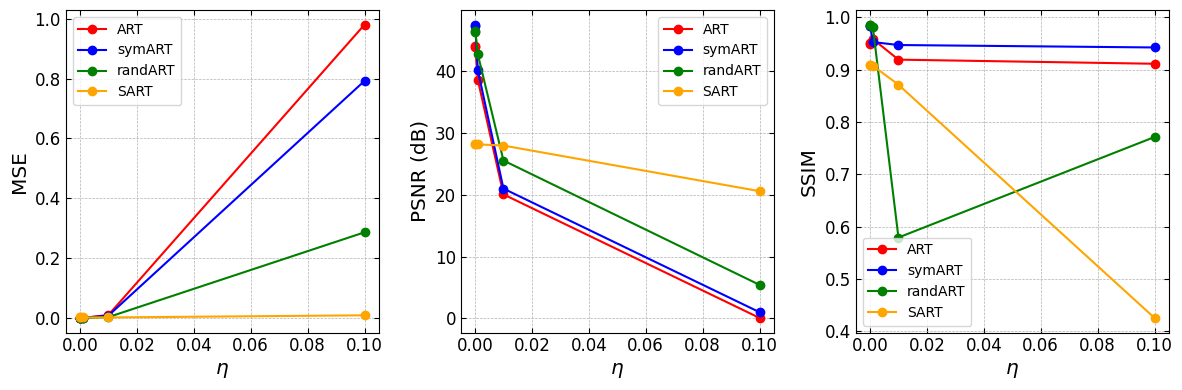

In [21]:
mse_a = []
mse_sym = []
mse_rand = []
mse_sart = []
psnr_a = []
psnr_sym = []
psnr_rand = []
psnr_sart = []
ssim_a = []
ssim_sym = []
ssim_rand = []
ssim_sart = []

for file_art, file_sym, file_rand, file_sart in zip(files_ruido, files_ruido_sym, files_ruido_rand, files_ruido_sart): 
    path_actual = os.path.join(path, file_art)
    path_sym = os.path.join(path, file_sym)
    path_rand = os.path.join(path, file_rand)
    path_sart = os.path.join(path, file_sart)
    
    reconstruccion_art = loadmat(path_actual)['ART']
    reconstruccion_sym = loadmat(path_sym)['symART']
    reconstruccion_rand = loadmat(path_rand)['randART']
    reconstruccion_sart = loadmat(path_sart)['SART']

    mse_a.append(mse(fantoma_original, reconstruccion_art))
    psnr_a.append(psnr(fantoma_original, reconstruccion_art))
    ssim_a.append(ssim(fantoma_original, reconstruccion_art, data_range=reconstruccion_art.max()-reconstruccion_art.min()))

    mse_sym.append(mse(fantoma_original, reconstruccion_sym))
    psnr_sym.append(psnr(fantoma_original, reconstruccion_sym))
    ssim_sym.append(ssim(fantoma_original, reconstruccion_sym, data_range=reconstruccion_sym.max()-reconstruccion_sym.min()))

    mse_rand.append(mse(fantoma_original, reconstruccion_rand))
    psnr_rand.append(psnr(fantoma_original, reconstruccion_rand))
    ssim_rand.append(ssim(fantoma_original, reconstruccion_rand, data_range=reconstruccion_rand.max()-reconstruccion_rand.min()))

    mse_sart.append(mse(fantoma_original, reconstruccion_sart))
    psnr_sart.append(psnr(fantoma_original, reconstruccion_sart))
    ssim_sart.append(ssim(fantoma_original, reconstruccion_sart, data_range=reconstruccion_sart.max()-reconstruccion_sart.min()))


fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot(eta_list, mse_a, '-o', color='red')
ax[0].plot(eta_list, mse_sym, '-o', color='blue')
ax[0].plot(eta_list, mse_rand, '-o', color='green')
ax[0].plot(eta_list, mse_sart, '-o', color='orange')
ax[0].legend(['ART', 'symART', 'randART', 'SART'])
ax[0].set_xlabel('$\eta$', fontsize='x-large')
ax[0].set_ylabel('MSE', fontsize='x-large')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].grid(linestyle = '--', lw = 0.5)
ax[1].plot(eta_list, psnr_a, '-o', color = 'red')
ax[1].plot(eta_list, psnr_sym, '-o', color = 'blue')
ax[1].plot(eta_list, psnr_rand, '-o', color = 'green')
ax[1].plot(eta_list, psnr_sart, '-o', color = 'orange')
ax[1].legend(['ART', 'symART', 'randART', 'SART'])
ax[1].set_xlabel('$\eta$', fontsize='x-large')
ax[1].set_ylabel('PSNR (dB)', fontsize='x-large')
ax[1].grid(linestyle = '--', lw = 0.5)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].plot(eta_list, ssim_a, '-o', color = 'red')
ax[2].plot(eta_list, ssim_sym, '-o', color = 'blue')
ax[2].plot(eta_list, ssim_rand, '-o', color = 'green')
ax[2].plot(eta_list, ssim_sart, '-o', color = 'orange')
ax[2].legend(['ART', 'symART', 'randART', 'SART'])
ax[2].set_xlabel('$\eta$', fontsize='x-large')
ax[2].set_ylabel('SSIM', fontsize='x-large')
ax[2].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].grid(linestyle = '--', lw = 0.5)
plt.tight_layout()
plt.savefig('metricas_ruido.pdf')
plt.show()

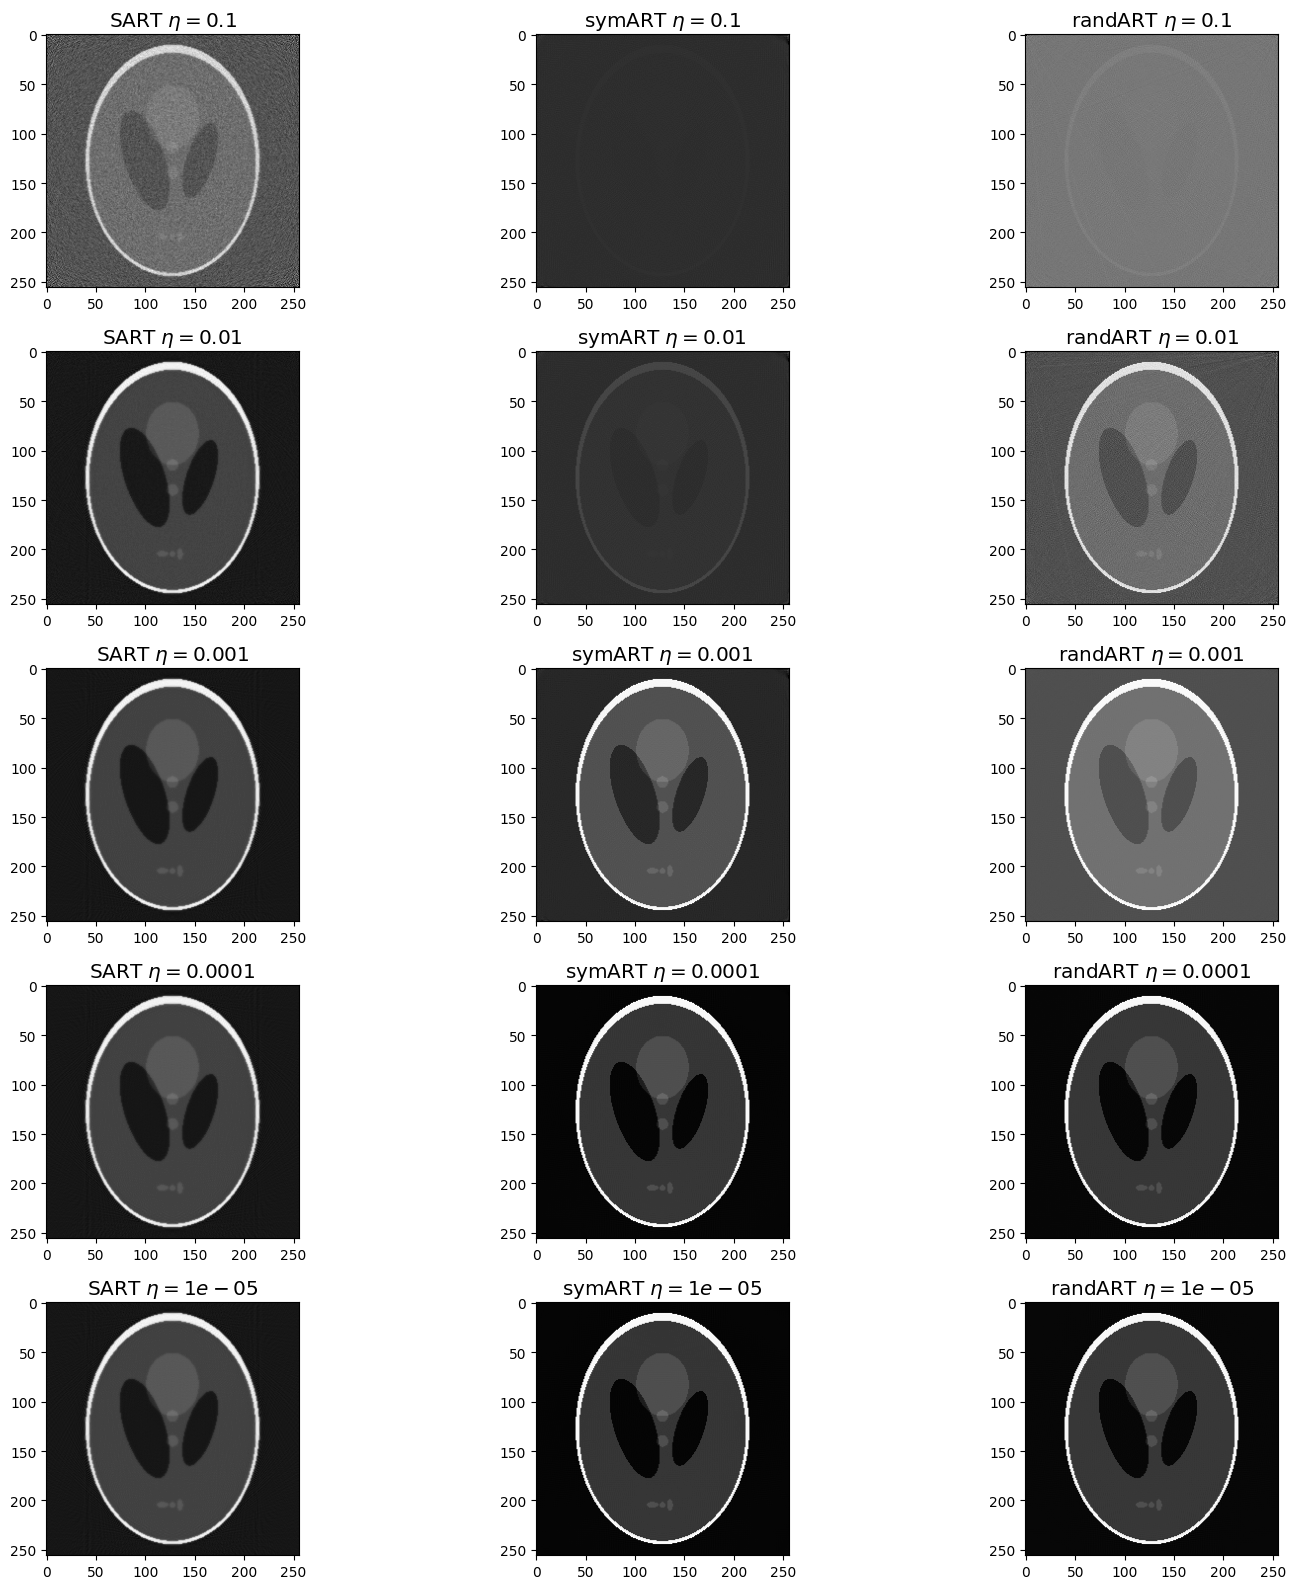

In [25]:
eta_list = [0.1, 0.01, 0.001, 1e-4, 1e-5]
fig, ax = plt.subplots(5,3,figsize=(16, 16))
for i, (eta, sart, sym, rand) in enumerate(zip(eta_list, files_ruido_sart, files_ruido_sym, files_ruido_rand)):
    path_sart = os.path.join(path, sart)
    path_sym = os.path.join(path, sym)
    path_rand = os.path.join(path, rand)
    reconstruccion_sart = loadmat(path_sart)['SART']
    reconstruccion_sym = loadmat(path_sym)['symART']
    reconstruccion_rand = loadmat(path_rand)['randART']
    ax[i,0].imshow(reconstruccion_sart, cmap='gray')
    ax[i,0].set_title('SART $\eta = {}$'.format(eta), fontsize='x-large')
    ax[i,1].imshow(reconstruccion_sym, cmap='gray')
    ax[i,1].set_title('symART $\eta = {}$'.format(eta), fontsize='x-large')
    ax[i,2].imshow(reconstruccion_rand, cmap='gray')
    ax[i,2].set_title('randART $\eta = {}$'.format(eta), fontsize='x-large')
plt.tight_layout()
plt.savefig('rnoise.pdf')
plt.show()

## Expectation maximization

In [5]:
files_em_show = ["EM_k10.mat", "EM_k100.mat", "EM_k180.mat", "EM_k500.mat"]

num_k = list(np.arange(10,510,10))
files_em = []
for k in num_k:
    files_em.append("EM_k{}.mat".format(k))
num_k_show = [10,100,180,500]

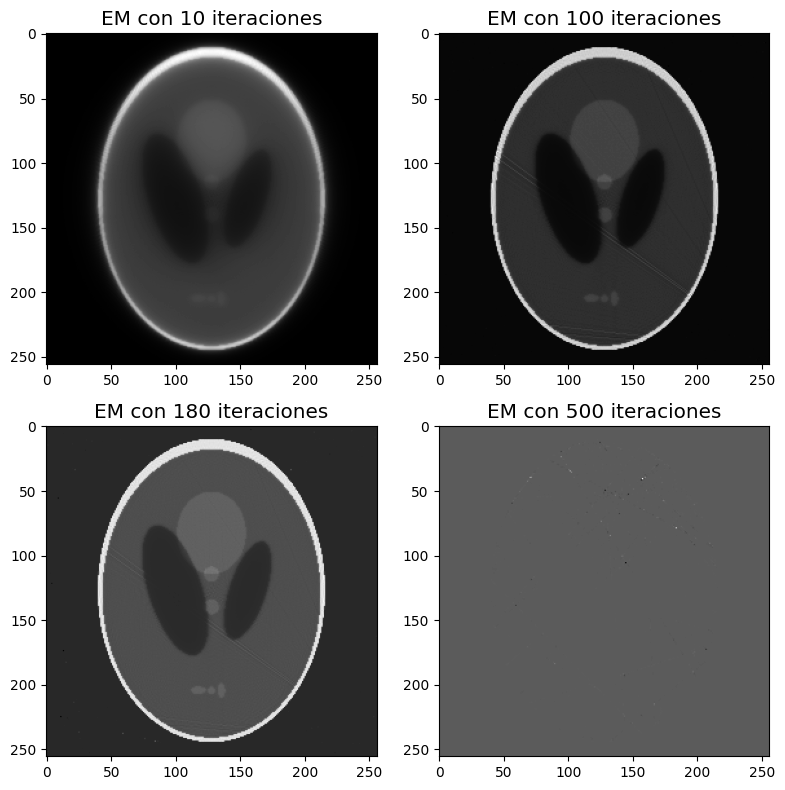

In [6]:
fig, ax = plt.subplots(2,2,figsize=(8, 8))
for i, (k, file) in enumerate(zip(num_k_show, files_em_show)):
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['EMr']
    if i == 0 or i == 1:
        ax[0,i].imshow(reconstruccion_fantoma, cmap='gray')
        ax[0,i].set_title('EM con {} iteraciones'.format(k), fontsize='x-large')
    else:
        ax[1,i%2].imshow(reconstruccion_fantoma, cmap='gray')
        ax[1,i%2].set_title('EM con {} iteraciones'.format(k), fontsize='x-large')
plt.tight_layout()
plt.savefig('EM_iteraciones.pdf')
plt.show()

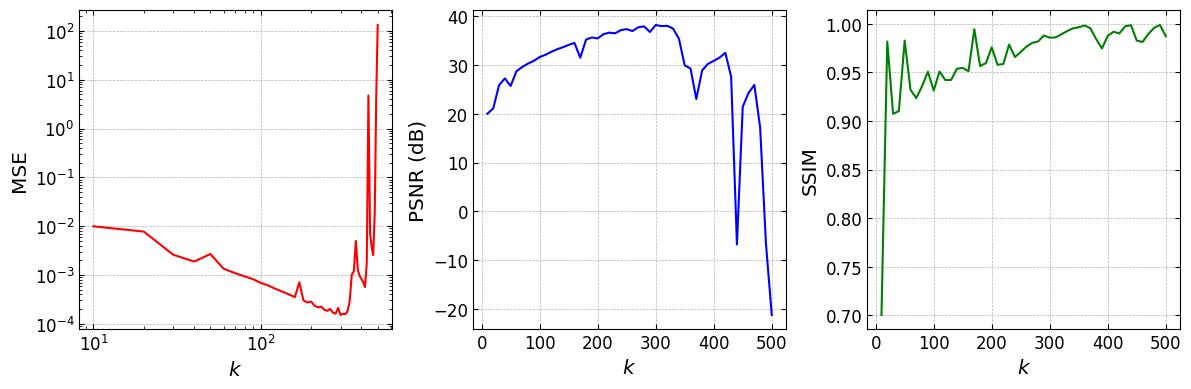

In [8]:
mse_em = []
psnr_em = []
ssim_em = []
for n, file in zip(num_k, files_em): 
    path_actual = os.path.join(path, file)
    reconstruccion_fantoma = loadmat(path_actual)['EMr']
    mse_em.append(mse(fantoma_original, reconstruccion_fantoma))
    psnr_em.append(psnr(fantoma_original, reconstruccion_fantoma))
    ssim_em.append(ssim(fantoma_original, reconstruccion_fantoma, data_range=reconstruccion_fantoma.max()-reconstruccion_fantoma.min()))

fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot(num_k, mse_em, color='red')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$k$', fontsize='x-large')
ax[0].set_ylabel('MSE', fontsize='x-large')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].grid(linestyle = '--', lw = 0.5)
ax[1].plot(num_k, psnr_em, color = 'blue')
ax[1].set_xlabel('$k$', fontsize='x-large')
ax[1].set_ylabel('PSNR (dB)', fontsize='x-large')
ax[1].grid(linestyle = '--', lw = 0.5)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].plot(num_k, ssim_em, color = 'green')
ax[2].set_xlabel('$k$', fontsize='x-large')
ax[2].set_ylabel('SSIM', fontsize='x-large')
ax[2].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[2].grid(linestyle = '--', lw = 0.5)
plt.tight_layout()
plt.savefig('em_metricas_iteraciones.pdf')
plt.show()

## Tiempo que toma cada método
En MATLAB se tomó el tiempo que tarda cada método en ejecutarse, se obutvieron los siguientes resultados

* Perform k = 100 iterations with Kaczmarz's method.
This takes a moment ...Elapsed time is 590.926890 seconds.

* Perform k = 100 iterations with the symmetric Kaczmarz method.
This takes a moment ...
Elapsed time is 1170.725236 seconds.


* Perform k = 100 iterations with the randomized Kaczmarz method.
This takes a moment ...
Elapsed time is 598.011474 seconds.


* Perform k = 100 iterations with SART method.
This takes a moment ...Elapsed time is 5.759605 seconds.

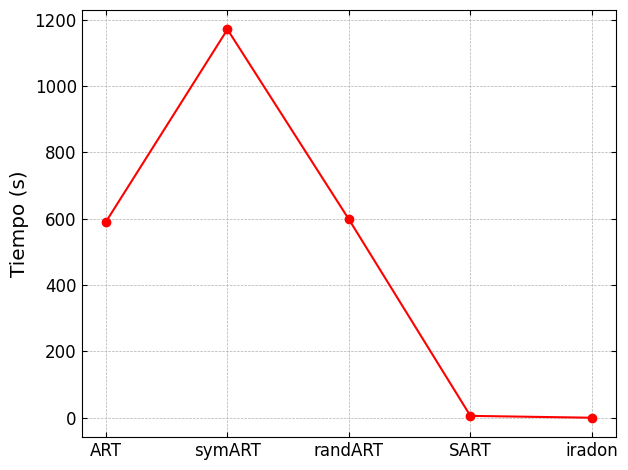

In [43]:
time = [590.926890, 1170.725236, 598.011474, 5.759605, 0.2]
xticks = ['ART', 'symART', 'randART', 'SART', 'iradon']
plt.plot(time, '-o', color='red')
plt.xticks(range(5), xticks)
plt.ylabel('Tiempo (s)', fontsize='x-large')
plt.grid(linestyle = '--', lw = 0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
plt.tight_layout()
plt.savefig('comparacion_tiempo.pdf')
plt.show()

In [38]:
def read_pgm_file(file_name, path = r'C:\Users\Propietario\Desktop\ib\5-Maestría\Imágenes Médicas\Practicas\Practica3\Ejercicio1\\'):
    """ Función que lee un archivo .pgm

    Args:
        file_name (str): Nombre del archivo .pgm
        path (str): Ruta donde se encuentra el archivo .pgm

    Returns:
        img (np.array): Imagen en formato de array de numpy
    """
    # Para abrir la imagen hay que cambiar el directorio a la carpeta donde está la imagen
    data_dir = os.path.dirname(path)

    # Vemos si la imagen existe
    file_path = os.path.join(data_dir, file_name)
    assert os.path.isfile(file_path), 'file \'{0}\' does not exist'.format(file_path)

    # Leemos la imágen utilizando OpenCV, con la bandera cv2.IMREAD_GRAYSCALE que indica que se leerá en escala de grises
    img = cv2.imread(file_name,flags=cv2.IMREAD_GRAYSCALE)

    # Si la imagen se leyó correctamente, mostramos su tamaño sinó mostramos un mensaje de error
    if img is not None:
        print('img.size: ', img.size)
    else:
        print('imread({0}) -> None'.format(file_path))

    return img

In [39]:
file_eqFantoma = 'FantomaEqualizado.pgm' # Fantoma equalizado con ImageJ dejando el 0.35% de saturados
img_eq = read_pgm_file(file_eqFantoma)

img.size:  65536


In [42]:
theta = np.linspace(0., 180., 360, endpoint=False)
sinogram = radon(img_eq, theta=theta)
%timeit iradon(sinogram, theta=theta, filter_name='ramp')

198 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
